
# Assignment-8: Apply Decision Tree On Amazon Fine Food Reviews DataSet 

## Introduction 

(i).A decision tree is a flowchart-like structure in which each internal node represents a “test” on an attribute (e.g. whether a coin flip comes up heads or tails), each branch represents the outcome of the test, and each leaf node represents a class label (decision taken after computing all attributes). The paths from root to leaf represent classification rules.

## Objective

To Predict the Polarity of Amazon Fine Food Review Using Decision Tree Algorithm.

## Importing All Required Library

In [38]:
%matplotlib inline
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import TimeSeriesSplit

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from gensim.models import Word2Vec
from gensim.models import KeyedVectors


import pickle


from tqdm import tqdm
import os
import warnings
warnings.filterwarnings("ignore")

## Importing Amazon Fine Food Review  Dataset

In [39]:
if os.path.isfile("final.sqlite"):
    conn=sqlite3.connect("final.sqlite")
    Data=pd.read_sql_query("select * from Reviews where Score!=3",conn)
    conn.close()
else :
    print("Error Importing the file")

In [40]:
# Printing some data of DataFrame

Data['Score'].value_counts()

1    307061
0     57110
Name: Score, dtype: int64

## Information About DataSet

In [41]:
print("\nNumber of Reviews: ",Data["Text"].count())
print("\nNumber of Users: ",len(Data["UserId"].unique())) # Unique returns 1-D array of unique values of DataFrame.
print("\nNumber of Products: ",len(Data["ProductId"].unique()))
print("\nShape of Data: ", Data.shape)
print("\nColumn Name of DataSet : ",Data.columns)
print("\n\nNumber of Attributes/Columns in data: 12") 
print("\nNumber of Positive Reviews : ", Data['Score'].value_counts()[1])
print("\nNumber of Negative Reviews : ", Data['Score'].value_counts()[0])


Number of Reviews:  364171

Number of Users:  243414

Number of Products:  65442

Shape of Data:  (364171, 12)

Column Name of DataSet :  Index(['index', 'Id', 'ProductId', 'UserId', 'ProfileName',
       'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time',
       'Summary', 'Text', 'CleanedText'],
      dtype='object')


Number of Attributes/Columns in data: 12

Number of Positive Reviews :  307061

Number of Negative Reviews :  57110


In [42]:
print("\nNumber of Reviews: ",Data["Text"].count())


Number of Reviews:  364171


## Attribute Information About DataSet

1.Id - A unique value starts from 1



2.ProductId - A unique identifier for the product



3.UserId - A unqiue identifier for the user



4.ProfileName - Name of user profile 



5.HelpfulnessNumerator - Number of users who found the review helpful



6.HelpfulnessDenominator - Number of users who indicated whether they found the review helpful or not



7.Score - Rating 0 or 1



8.Time - Timestamp for the review



9.Summary - Brief summary of the review



10.Text - Text of the review



11.Cleaned Text - Text that only alphabets

In [43]:
# Sorting on the basis of Time Parameter
Data.sort_values('Time',inplace=True)

In [44]:
Data=Data.head(100000)

In [45]:
Y = Data['Score']
X = Data['CleanedText']

## Splitting DataSet into Train and Test Data

In [46]:
from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, shuffle=Flase): this is for time series split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33,shuffle=False) # this is random splitting

print("Shape of Train and Test Dataset for 100k points")
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

Shape of Train and Test Dataset for 100k points
(67000,) (67000,)
(33000,) (33000,)


## Defining Some Function

###  Train Data Confusion Matrix Plot

In [47]:
def trainconfusionmatrix(model,X_train,y_train):
    print("Confusion Matrix for Train set")
    cm=confusion_matrix(y_train, model.predict(X_train))
    class_label = ["negative", "positive"]
    df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
    sns.heatmap(df_cm, annot = True, fmt = "d")
    plt.title("Train Confusiion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

### Test Data Confusion Matrix Plot

In [48]:
def testconfusionmatrix(model,X_test,y_test):
    print("Confusion Matrix for Test set")
    cm=confusion_matrix(y_test, model.predict(X_test))
    class_label = ["negative", "positive"]
    df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
    sns.heatmap(df_cm, annot = True, fmt = "d")
    plt.title("Test Confusiion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

### ROC-AUC Curve 

In [49]:
def plot_auc_roc(model,X_train,X_test,y_train,y_test):
    train_fpr, train_tpr, thresholds = roc_curve(y_train,model.predict_proba(X_train)[:,1])
    test_fpr, test_tpr, thresholds = roc_curve(y_test,model.predict_proba(X_test)[:,1])

    plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
    plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
    plt.legend()
    plt.xlabel("Hyperameter (C)")
    plt.ylabel("AUC")
    plt.title("ROC CURVE PLOTS")
    plt.show()

### Plot 

In [50]:
def plot(gsv):
    res=gsv.cv_results_
    cv_data=res['mean_test_score']
    train_data=res['mean_train_score']
    depth=[1, 1, 1, 1, 5, 5, 5, 5, 10, 10, 10, 10, 50, 50, 50, 50,
                    100, 100, 100, 100, 500, 500, 500, 500, 1000, 1000,
                    1000, 1000]     
    
   
    plt.xlabel("Hyperparameter (Max_Depth)",fontsize=15)
    plt.ylabel("Mean_Score",fontsize=15)
    plt.title('Mean Score v/s Max_Depth',fontsize=15)
    plt.plot(depth,cv_data,label="Cross-Validation")
    plt.plot(depth,train_data,label="Train")
    plt.legend()
    plt.show()

### GridSearchCV

In [51]:
def Grid_SearchCV(X_train,Y_train):
    
    param_grid= {'max_depth':[1,5,10,50,100,500,1000],
                  'min_samples_split':[5,10,100,500]
                } 
    tscv = TimeSeriesSplit(n_splits=10)
    clf = DecisionTreeClassifier(class_weight='balanced')
    gsv=GridSearchCV(clf,param_grid, scoring = 'roc_auc', cv=tscv,n_jobs=-1,pre_dispatch=2)
    gsv.fit(X_train,Y_train)
    
    return gsv

### 30 Informative Feature

In [52]:
 def show_30_informative_feature(vectorizer,model,n=30):
        
        
    Weights_Index = model.feature_importances_.argsort()
    length = len(Weights_Index)
    # For Negative Class
    neg_class=Weights_Index[:n]
    
    neg_feat=[vectorizer.get_feature_names()[x] for x in neg_class]
    neg_prob=[Weights_Index[x] for x in neg_class]
    
    neg_zip=list(zip(neg_feat,neg_prob))
    neg_zip.sort()
    
    # For Positive Class 
    pos_class =  Weights_Index[-30:]
    
    pos_feat=[vectorizer.get_feature_names()[x] for x in pos_class]
    pos_prob=[Weights_Index[x] for x in pos_class]
    pos_zip=list(zip(pos_feat,pos_prob))
    pos_zip.sort()
    
    top=zip(pos_zip,neg_zip)
    
    print("{0:20}{1:55}{2:20}".format("S.N","Positive","Negative"))
    print("_"*90)
    i=1
    for (fn_1,coef_1), (fn_2,coef_2) in top:
        print("%d.\t\t%.3f\t%-30s\t\t%.3f\t%s" % (i,coef_1, fn_1, coef_2, fn_2))
        i+=1
    
    

## Bags of Words Vectorizer

In [17]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_bow = vectorizer.transform(X_train)
X_train_bow=preprocessing.normalize(X_train_bow)

X_test_bow = vectorizer.transform(X_test)
X_test_bow=preprocessing.normalize(X_test_bow)

print("Shape of Train and Test Data After vectorizations")
print(X_train_bow.shape, Y_train.shape)
print(X_test_bow.shape, Y_test.shape)

Shape of Train and Test Data After vectorizations
(67000, 30737) (67000,)
(33000, 30737) (33000,)


### Finding the best value Of hyperparameter (Alpha)

In [18]:
gsv=Grid_SearchCV(X_train_bow,Y_train)

print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Best HyperParameter:  {'max_depth': 50, 'min_samples_split': 500}
Best Accuracy: 77.10%


### Plot

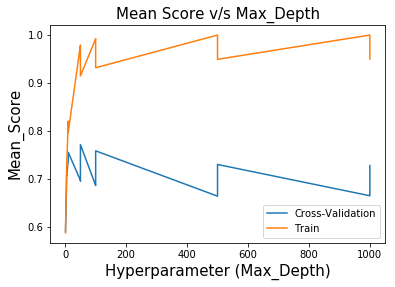

In [19]:
plot(gsv)

### Training the model

In [60]:
Best_Param=gsv.best_params_
depth=Best_Param['max_depth']
min_sample_split = Best_Param['min_samples_split']

Model_Bow=DecisionTreeClassifier(max_depth=depth,min_samples_split=min_sample_split,class_weight="balanced")
Model_Bow.fit(X_train_bow,Y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=10, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [44]:
from sklearn.externals import joblib 
joblib.dump(Model_Bow,"BOW_Model.pkl")

['BOW_Model.pkl']

In [18]:
from sklearn.externals import joblib
Model_Bow=joblib.load("BOW_Model.pkl")

### Evaluating the performance of model

Confusion Matrix for Train set


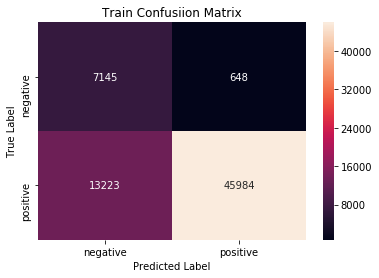

In [19]:
trainconfusionmatrix(Model_Bow,X_train_bow,Y_train)

Confusion Matrix for Test set


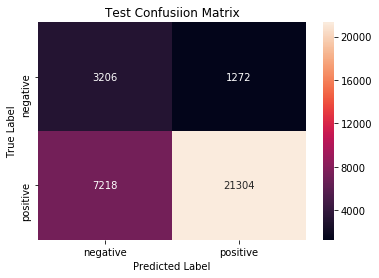

In [20]:
testconfusionmatrix(Model_Bow,X_test_bow,Y_test)

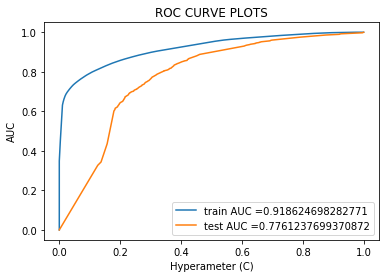

In [21]:
plot_auc_roc_L(Model_Bow,X_train_bow,X_test_bow,Y_train,Y_test)

In [24]:
print("Classification Report: \n")
y_pred=Model_Bow.predict(X_test_bow)

print(classification_report(Y_test, y_pred))


Classification Report: 

              precision    recall  f1-score   support

           0       0.31      0.72      0.43      4478
           1       0.94      0.75      0.83     28522

   micro avg       0.74      0.74      0.74     33000
   macro avg       0.63      0.73      0.63     33000
weighted avg       0.86      0.74      0.78     33000



### Displaying 30 most informative features

In [31]:
show_30_informative_feature(vectorizer,Model_Bow)

S.N                 Positive                                               Negative            
__________________________________________________________________________________________
1.		19621.000	aw                            		0.000	aaa
2.		19612.000	away                          		190.000	pkgs
3.		19738.000	bad                           		189.000	pkirk
4.		22766.000	best                          		188.000	pks
5.		17382.000	delici                        		187.000	pkt
6.		17892.000	disappoint                    		186.000	pkts
7.		28778.000	easi                          		185.000	pku
8.		27298.000	enjoy                         		184.000	pkwi
9.		27608.000	excel                         		183.000	pla
10.		30096.000	favorit                       		182.000	placat
11.		30171.000	find                          		181.000	place
12.		29401.000	good                          		180.000	placebo
13.		24408.000	great                         		205.000	placement
14.		23137.000	howev                 

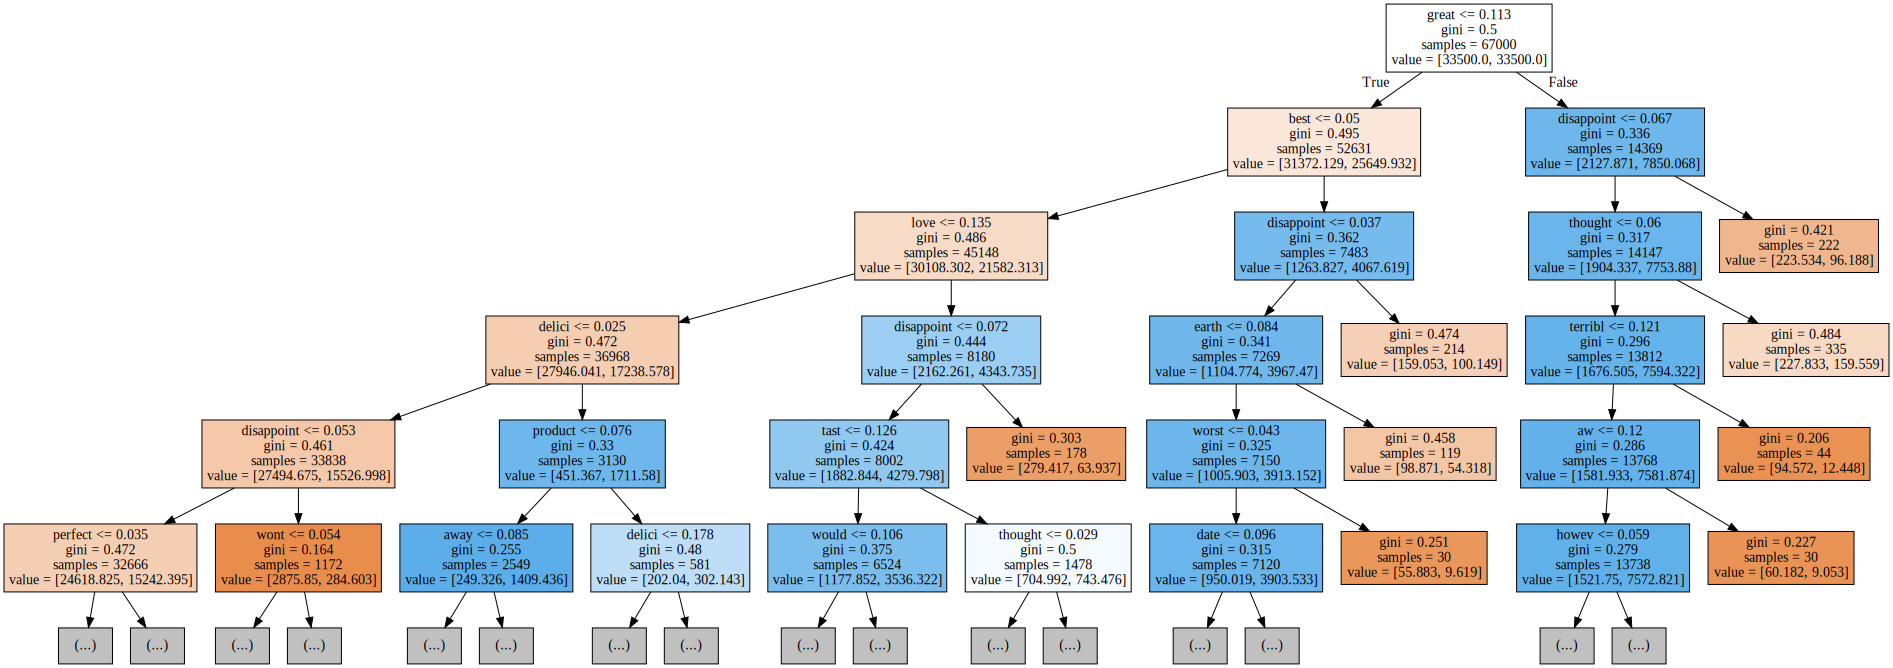

In [25]:
from sklearn.tree import export_graphviz
import graphviz

export_graphviz(Model_Bow,out_file="BOW.dot",feature_names=vectorizer.get_feature_names(),filled=True,max_depth=5)
with open("BOW.dot") as f:
    dot_graph=f.read()
graphviz.Source(dot_graph)    

In [66]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

## TF-IDF Vectorizer

In [53]:
vectorizer_tfidf=TfidfVectorizer()
vectorizer_tfidf.fit(X_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [54]:
X_Train_Tfidf=vectorizer_tfidf.transform(X_train)
X_Train_Tfidf=preprocessing.normalize(X_Train_Tfidf)

X_Test_Tfidf=vectorizer_tfidf.transform(X_test)
X_Test_Tfidf=preprocessing.normalize(X_Test_Tfidf)

In [55]:
print("Shape of Train and Test Data After vectorizations")
print(X_Train_Tfidf.shape, Y_train.shape)
print(X_Test_Tfidf.shape, Y_test.shape)

Shape of Train and Test Data After vectorizations
(67000, 30737) (67000,)
(33000, 30737) (33000,)


### Finding the best value Of hyperparameter (Alpha ) 

In [56]:
gsv=Grid_SearchCV(X_Train_Tfidf,Y_train)

print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Best HyperParameter:  {'max_depth': 50, 'min_samples_split': 500}
Best Accuracy: 77.41%


### Plot

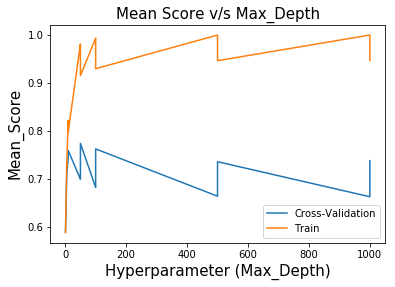

In [57]:
plot(gsv)

### Training the model

In [58]:
Best_Param=gsv.best_params_
depth=Best_Param['max_depth']
min_sample_split = Best_Param['min_samples_split']

Model_Tfidf=DecisionTreeClassifier(max_depth=depth,min_samples_split=min_sample_split,class_weight="balanced")
Model_Tfidf.fit(X_Train_Tfidf,Y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=50, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

### Evaluating the performance of model

Confusion Matrix for Train set


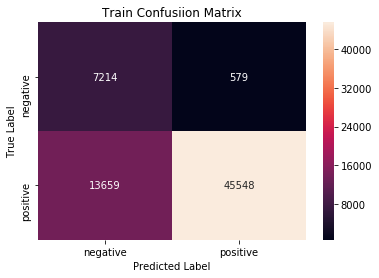

In [59]:
trainconfusionmatrix(Model_Tfidf,X_Train_Tfidf,Y_train)

Confusion Matrix for Test set


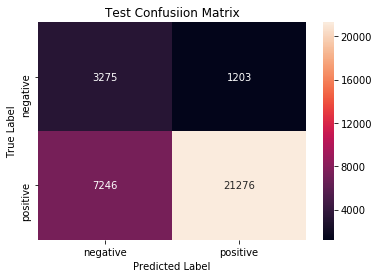

In [60]:
testconfusionmatrix(Model_Tfidf,X_Test_Tfidf,Y_test)

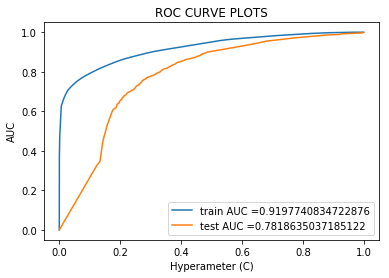

In [62]:
plot_auc_roc(Model_Tfidf,X_Train_Tfidf,X_Test_Tfidf,Y_train,Y_test)

In [63]:
print("Classification Report: \n")
y_pred=Model_Tfidf.predict(X_Test_Tfidf)

print(classification_report(Y_test, y_pred))

Classification Report: 

              precision    recall  f1-score   support

           0       0.31      0.73      0.44      4478
           1       0.95      0.75      0.83     28522

   micro avg       0.74      0.74      0.74     33000
   macro avg       0.63      0.74      0.64     33000
weighted avg       0.86      0.74      0.78     33000



### Displaying 30 most informative features

In [64]:
show_30_informative_feature(vectorizer_tfidf,Model_Tfidf)

S.N                 Positive                                               Negative            
__________________________________________________________________________________________
1.		20573.000	alway                         		0.000	aaa
2.		20606.000	amaz                          		185.000	pix
3.		19609.000	aw                            		184.000	pixar
4.		19600.000	away                          		183.000	pixi
5.		19726.000	bad                           		182.000	pizaaz
6.		22758.000	best                          		207.000	pizazz
7.		17364.000	delici                        		208.000	pizel
8.		17870.000	disappoint                    		209.000	pizell
9.		28703.000	easi                          		210.000	pizza
10.		27349.000	enjoy                         		237.000	pizzaz
11.		27608.000	excel                         		236.000	pizzazz
12.		30083.000	favorit                       		235.000	pizzeria
13.		29855.000	find                          		234.000	pizzl
14.		29478.000	good        

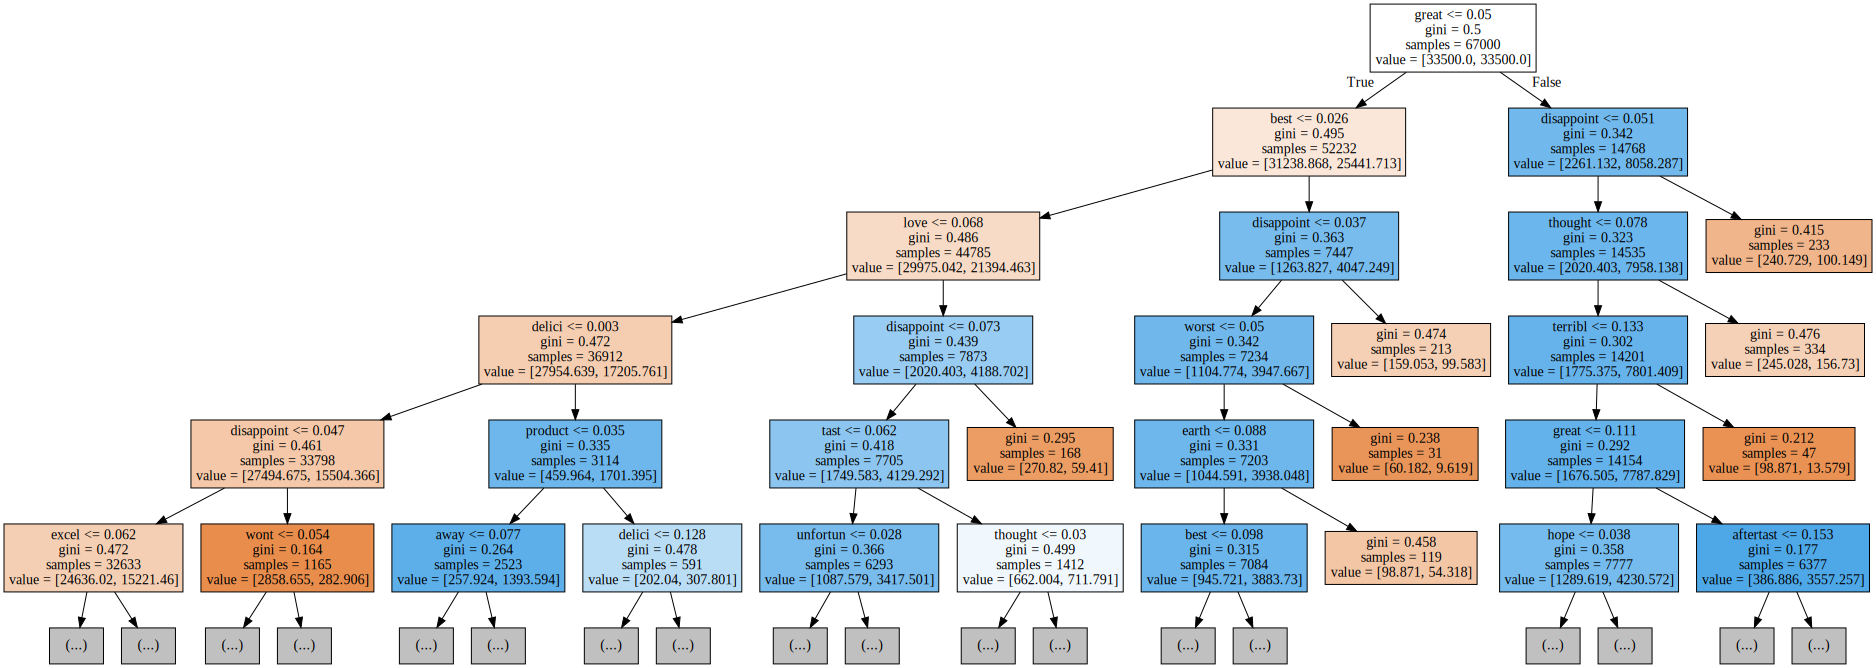

In [67]:
from sklearn.tree import export_graphviz
import graphviz

export_graphviz(Model_Tfidf,out_file="Tfidf.dot",feature_names=vectorizer_tfidf.get_feature_names(),filled=True,max_depth=5)
with open("Tfidf.dot") as f:
    dot_graph=f.read()
graphviz.Source(dot_graph)  

## Word To Vector

In [17]:
list_of_Train_sent=[]
list_of_Test_sent=[]

for sent in X_train:
    list_of_Train_sent.append(sent.split())
    
for sent in X_test:
    list_of_Test_sent.append(sent.split())

In [18]:
model=Word2Vec(list_of_Train_sent,min_count=5,size=50, workers=4)

## Average Word To Vector

In [49]:
import numpy as np

Train_vectors = []
for sent in list_of_Train_sent:
    sent_vec = np.zeros(50)
    cnt_words = 0
    for word in sent:
        try:
            vec = model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    if cnt_words!=0:    
        sent_vec /= cnt_words
    Train_vectors.append(sent_vec)
Train_vectors = np.nan_to_num(Train_vectors)

In [50]:
import numpy as np

Test_vectors=[]
for sent in list_of_Test_sent:
    sent_vec=np.zeros(50)
    cnt_words=0
    for word in sent:
        try:
            vec=model.wv[word]
            sent_vec+=vec
            cnt_words+=1
        except:
            pass
    if cnt_words!=0:
        sent_vec/=cnt_words
    Test_vectors.append(sent_vec)
Test_vectors=np.nan_to_num(Test_vectors)    

In [51]:
print("Shape of Test Vectors : ",Test_vectors.shape)

Shape of Test Vectors :  (33000, 50)


In [52]:
X_Train_Awv=Train_vectors
X_Test_Awv=Test_vectors

In [53]:
print(X_Train_Awv.shape, Y_train.shape)
print(X_Test_Awv.shape, Y_test.shape)

(67000, 50) (67000,)
(33000, 50) (33000,)


### Finding the best value Of hyperparameter (Alpha) 

In [54]:
gsv=Grid_SearchCV(X_Train_Awv,Y_train)

print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Best HyperParameter:  {'max_depth': 10, 'min_samples_split': 500}
Best Accuracy: 77.57%




### Plot

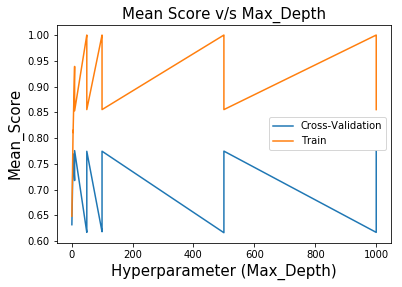

In [55]:
plot(gsv)

### Training Model 

In [61]:
Best_Param=gsv.best_params_
depth=Best_Param['max_depth']
min_sample_split = Best_Param['min_samples_split']

Model_Awv=DecisionTreeClassifier(max_depth=depth,min_samples_split=min_sample_split,class_weight="balanced")
Model_Awv.fit(X_Train_Awv,Y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=10, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

### Evaluating the performance of model

Confusion Matrix for Train set


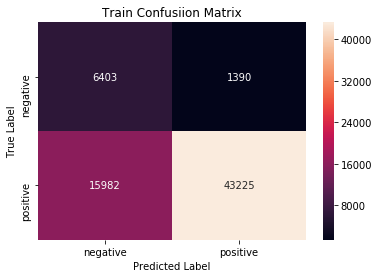

In [62]:
trainconfusionmatrix(Model_Awv,X_Train_Awv,Y_train)

Confusion Matrix for Train set


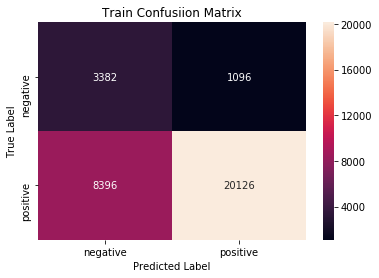

In [63]:
trainconfusionmatrix(Model_Awv,X_Test_Awv,Y_test)

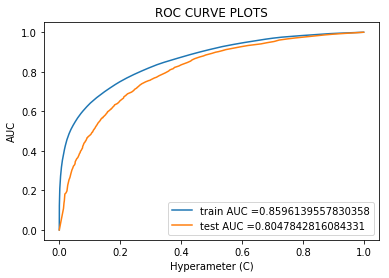

In [64]:
plot_auc_roc_L(Model_Awv,X_Train_Awv,X_Test_Awv,Y_train,Y_test)

In [65]:
print("Classification Report: \n")
y_pred=Model_Awv.predict(X_Test_Awv)

print(classification_report(Y_test, y_pred))

Classification Report: 

              precision    recall  f1-score   support

           0       0.29      0.76      0.42      4478
           1       0.95      0.71      0.81     28522

   micro avg       0.71      0.71      0.71     33000
   macro avg       0.62      0.73      0.61     33000
weighted avg       0.86      0.71      0.76     33000



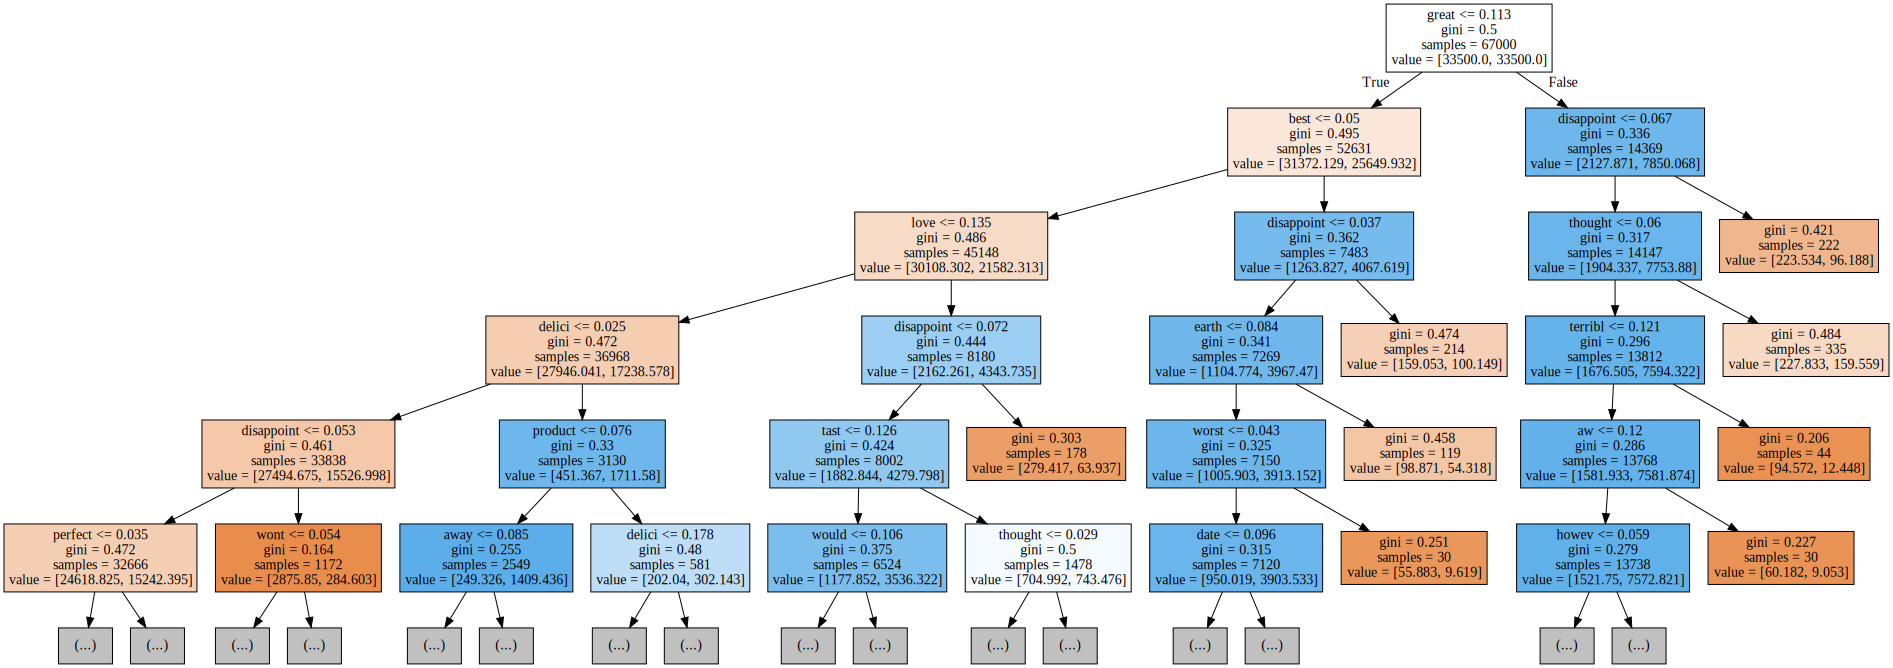

In [66]:
from sklearn.tree import export_graphviz
import graphviz

export_graphviz(Model_Awv,out_file="W2V.dot",feature_names=model.get_feature_names(),filled=True,max_depth=5)
with open("W2V.dot") as f:
    dot_graph=f.read()
graphviz.Source(dot_graph)  

## TF-IDF Word To Vector

In [19]:
TFIDF_Feature=vectorizer_tfidf.get_feature_names()
print(len(TFIDF_Feature))
print(TFIDF_Feature[0:20])

30737
['aaa', 'aaaaaaaaagghh', 'aaaaah', 'aaaaahhhhhhhhhhhhhhhh', 'aaaah', 'aaah', 'aachen', 'aad', 'aadp', 'aafco', 'aagh', 'aah', 'aahh', 'aand', 'aardvark', 'ab', 'aback', 'abandon', 'abaolut', 'abattoir']


In [20]:
w2v_words = list(model.wv.vocab)
print("Number of words that occured minimum 5 times ",len(w2v_words))
print("Sample words ", w2v_words[0:50])

Number of words that occured minimum 5 times  10488
Sample words  ['witti', 'littl', 'book', 'make', 'son', 'laugh', 'loud', 'car', 'drive', 'along', 'alway', 'sing', 'refrain', 'hes', 'learn', 'whale', 'india', 'droop', 'love', 'new', 'word', 'introduc', 'silli', 'classic', 'will', 'bet', 'still', 'abl', 'memori', 'colleg', 'rememb', 'see', 'show', 'air', 'televis', 'year', 'ago', 'child', 'sister', 'later', 'bought', 'day', 'thirti', 'someth', 'use', 'seri', 'song', 'student', 'teach', 'preschool']


In [21]:
from tqdm import tqdm
Train_TFIDF_W2V_Vectors=[]
row=0
for sent in tqdm(list_of_Train_sent):
    sent_vec=np.zeros(50)
    weight=0
    for word in sent:
        try :
            if word in TFIDF_Feature and word in w2v_words:
                
                w2v_vec=model.wv[word]
                tfidf_vec=X_Train_Tfidf[row,TFIDF_Feature.index(word)]
                sent_vec+=(w2v_vec*tfidf_vec)
                weight+=tfidf_vec
            
        except :
            pass
    if weight!=0:
        sent_vec/=weight
    Train_TFIDF_W2V_Vectors.append(sent_vec) 
    row+=1

100%|████████████████████████████████████| 67000/67000 [25:17<00:00, 44.15it/s]


In [22]:
Test_TFIDF_W2V_Vectors=[]
row=0
for sent in tqdm(list_of_Test_sent):
    sent_vec=np.zeros(50)
    weight=0
    
    for word in sent:
        try:
             if word in TFIDF_Feature and word in w2v_words:
                    
                w2v_vec=model.wv[word]
                tfidf_vec=X_Test_Tfidf(row,TFIDF_Feature.index(word))
                sent_vec+=(w2v_vec*tfidf_vec)
                weight+=tfidf
          
        except :
            pass
    
    if weight!=0:
        sent_vec/=weight
    Test_TFIDF_W2V_Vectors.append(sent_vec)    
    row+=1

100%|████████████████████████████████████| 33000/33000 [12:57<00:00, 42.42it/s]


In [23]:
Train_TFIDF_W2V_Vectors = np.nan_to_num(Train_TFIDF_W2V_Vectors)
Test_TFIDF_W2V_Vectors = np.nan_to_num(Test_TFIDF_W2V_Vectors)

In [24]:
X_Train_TfidfW2v=Train_TFIDF_W2V_Vectors
X_Test_TfidfW2v=Test_TFIDF_W2V_Vectors

In [25]:
print(X_Train_TfidfW2v.shape, Y_train.shape)
print(X_Test_TfidfW2v.shape, Y_test.shape)

(67000, 50) (67000,)
(33000, 50) (33000,)


### Finding the best value Of hyperparameter (Alpha) 

In [26]:
gsv=Grid_SearchCV(X_Train_TfidfW2v,Y_train)

print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Best HyperParameter:  {'max_depth': 1, 'min_samples_split': 5}
Best Accuracy: 50.00%


### Plot

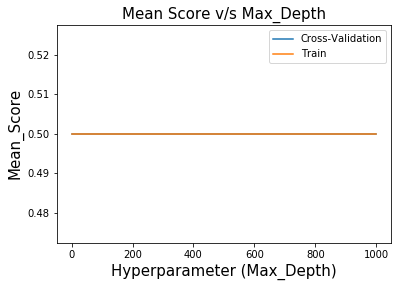

In [27]:
plot(gsv)

### Training Model

In [29]:
Best_Param=gsv.best_params_
depth=Best_Param['max_depth']
min_sample_split = Best_Param['min_samples_split']

Model_TfidfW2v=DecisionTreeClassifier(max_depth=depth,min_samples_split=min_sample_split,class_weight="balanced")
Model_TfidfW2v.fit(X_Train_TfidfW2v,Y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

### Evaluating the performance of model

Confusion Matrix for Train set


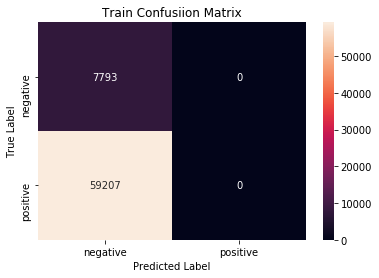

In [30]:
trainconfusionmatrix(Model_TfidfW2v,X_Train_TfidfW2v,Y_train)

Confusion Matrix for Test set


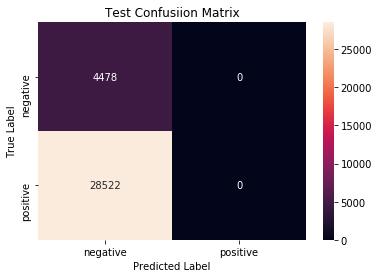

In [31]:
testconfusionmatrix(Model_TfidfW2v,X_Test_TfidfW2v,Y_test)

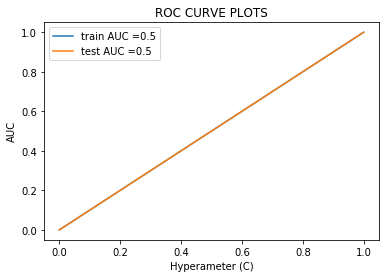

In [34]:
plot_auc_roc(Model_TfidfW2v,X_Train_TfidfW2v,X_Test_TfidfW2v,Y_train,Y_test)

In [35]:
print("Classification Report: \n")
y_pred=Model_TfidfW2v.predict(X_Test_TfidfW2v)

print(classification_report(Y_test, y_pred))

Classification Report: 

              precision    recall  f1-score   support

           0       0.14      1.00      0.24      4478
           1       0.00      0.00      0.00     28522

   micro avg       0.14      0.14      0.14     33000
   macro avg       0.07      0.50      0.12     33000
weighted avg       0.02      0.14      0.03     33000



### Conclusion :

1. Report On different Vectorizer method.

In [1]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Vectorizer", "Hyperparameter(Max_Depth)","Hyperparameter(Min_Samples_Split)","Train AUC","Test AUC","F1-Score"]

x.add_row(["BOW",50,500,0.91,0.76,0.78])
x.add_row(["TF-IDF",50,500,0.91,0.78,0.78])
x.add_row(["Avg W2V",10,500,0.85,0.80,0.76])
x.add_row(["TF-IDF W2V",1,5,0.5,0.5,0.03])

print(x)

+------------+---------------------------+-----------------------------------+-----------+----------+----------+
| Vectorizer | Hyperparameter(Max_Depth) | Hyperparameter(Min_Samples_Split) | Train AUC | Test AUC | F1-Score |
+------------+---------------------------+-----------------------------------+-----------+----------+----------+
|    BOW     |             50            |                500                |    0.91   |   0.76   |   0.78   |
|   TF-IDF   |             50            |                500                |    0.91   |   0.78   |   0.78   |
|  Avg W2V   |             10            |                500                |    0.85   |   0.8    |   0.76   |
| TF-IDF W2V |             1             |                 5                 |    0.5    |   0.5    |   0.03   |
+------------+---------------------------+-----------------------------------+-----------+----------+----------+


2. I have taken 100k points .

3. Model is performing very good in case of Average Word to Vector than others.

4. In case of TF-IDF W2V model is behaving like a dumb model.